In [ ]:
## SET LIBARY

In [1]:
import random
import numpy as np
np.random.seed(13)
import gensim

from keras.models import Model
from keras.layers import Embedding, Reshape, Activation, Input
from keras.preprocessing import sequence
from keras.layers.merge import Dot
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import skipgrams
from IPython.display import Image

Using TensorFlow backend.


In [ ]:
!pip install pydot
!pip install gensim

In [ ]:
## DATALOADER

In [3]:
def dataloader(sequence, vocabulary_size,
               window_size=window_size, negative_samples=1., shuffle=True,
               categorical=False, sampling_table=None, seed=None):
    # Objective: Generates skipgram word pairs
    # For Negative cases randomly generate some out-of-context word with the target word
    # Input: Word Sequence
    # Output: Word pairs and labels
    couples = []
    labels = []
    for i, wi in enumerate(sequence):
        if not wi:
            continue
        if sampling_table is not None:
            if sampling_table[wi] < random.random():
                continue

        window_start = max(0, i - window_size)
        window_end = min(len(sequence), i + window_size + 1)
        for j in range(window_start, window_end):
            if j != i:
                wj = sequence[j]
                if not wj:
                    continue
                couples.append([wi, wj])
                if categorical:
                    labels.append([0, 1])
                else:
                    labels.append(1)

    if negative_samples > 0:
        num_negative_samples = int(len(labels) * negative_samples)
        words = [c[0] for c in couples]
        random.shuffle(words)

        couples += [[words[i % len(words)],
                    random.randint(1, vocabulary_size - 1)]
                    for i in range(num_negative_samples)]
        if categorical:
            labels += [[1, 0]] * num_negative_samples
        else:
            labels += [0] * num_negative_samples

    if shuffle:
        if seed is None:
            seed = random.randint(0, 10e6)
        random.seed(seed)
        random.shuffle(couples)
        random.seed(seed)
        random.shuffle(labels)
        
    return couples, labels

In [24]:
path = get_file('alice.txt', origin='http://www.gutenberg.org/files/11/11-0.txt')
corpus = open(path, encoding="utf-8").readlines()
corpus = [sentence for sentence in corpus if sentence.count(' ') >= 2]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size: {}".format(vocab_size))

Vocabulary size: 3388


In [5]:
corpus[:5]

['\ufeffProject Gutenberg’s Alice’s Adventures in Wonderland, by Lewis Carroll\n',
 'This eBook is for the use of anyone anywhere at no cost and with\n',
 'almost no restrictions whatsoever.  You may copy it, give it away or\n',
 're-use it under the terms of the Project Gutenberg License included\n',
 'with this eBook or online at www.gutenberg.org\n']

In [9]:
for i, doc in enumerate(tokenizer.texts_to_sequences(corpus)):
    x_sample, y_sample = dataloader(sequence=doc, vocabulary_size=vocab_size, window_size=5, negative_samples=5.)
    break

In [13]:
print("Load data instances: {}".format(x_sample[:5]))
print("Format data into input data: {}".format([np.array(x) for x in zip(*x_sample[:5])]))
print("Load label instances: {}".format(y_sample[:5]))

Load data instances: [[479, 2466], [1005, 2918], [479, 1916], [1004, 420], [1823, 1693]]
Format data into input data: [array([ 479, 1005,  479, 1004, 1823]), array([2466, 2918, 1916,  420, 1693])]
Load label instances: [0, 0, 0, 0, 0]


In [ ]:
## SET SKIPGRAM GRAPH
## By taking pair of words from the document and then saying output is 1 in the case the second word is the context word.

In [6]:
dim_embed = 100

# Word Inputs
input_words = Input(shape=(1, ), dtype='int32')
embed_words = Embedding(vocab_size, dim_embed)(input_words)

# Context Inputs
input_ctxts = Input(shape=(1, ), dtype='int32')
embed_ctxts = Embedding(vocab_size, dim_embed)(input_ctxts)

output = Dot(axes=2)([embed_words, embed_ctxts])
output = Reshape((1, ), input_shape=(1, 1))(output)
output = Activation('sigmoid')(output)

gph = Model(inputs=[input_words, input_ctxts], outputs=output)
gph.compile(loss='binary_crossentropy', optimizer='adam')
gph.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       338800      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 100)       338800      input_2[0][0]                    
__________________________________________________________________________________________________
dot_1 (Dot

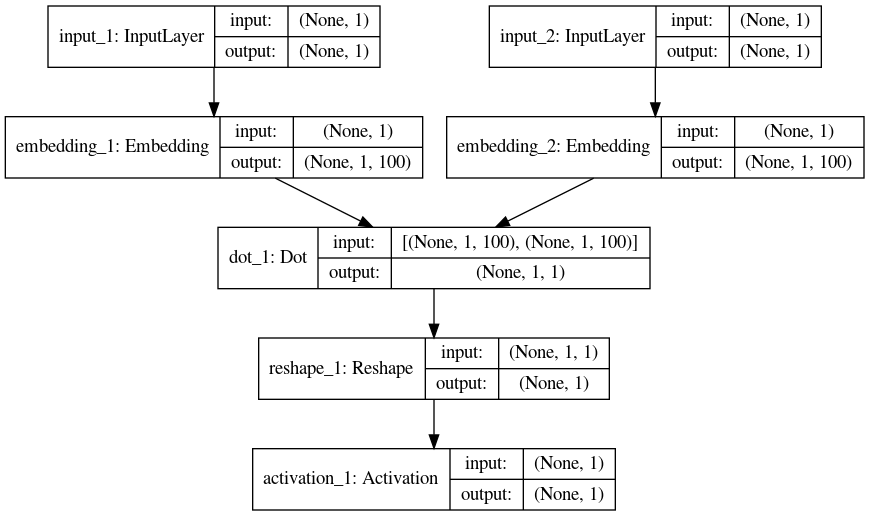

In [7]:
Image(model_to_dot(gph, show_shapes=True).create(prog='dot', format='png'))

In [ ]:
## TRAIN

In [16]:
for ite in range(5):
    loss = 0.
    for i, doc in enumerate(tokenizer.texts_to_sequences(corpus)):
        data, labels = dataloader(sequence=doc, vocabulary_size=vocab_size, window_size=5, negative_samples=5.)
        x = [np.array(x) for x in zip(*data)]
        y = np.array(labels, dtype=np.int32)
        if x:
            loss += gph.train_on_batch(x, y)
    print(ite, loss)

0 1097.907870143652
1 753.7180339954793
2 698.2168588116765
3 669.3916662968695
4 647.1412664018571


In [ ]:
## Embedding

In [30]:
embd = gph.get_weights()[0][:5,:]
for word, i in tokenizer.word_index.items():
    print('{} {}\n'.format(word, ' '.join(map(str, list(embd[i, :])))))
    if i == 4:
        break

the 0.06485613 0.19011748 -0.31508714 0.09316213 -0.3482375 0.06865945 -0.20542982 0.07245401 -0.1240688 -0.21135494 -0.068385385 -0.39660135 -0.076997794 -0.14815845 0.041868776 -0.10246736 -0.048519395 0.29590258 -0.4678977 -0.20503885 -0.071554676 -0.3550916 -0.08611552 0.059816264 -0.20631994 -0.31473446 -0.048809074 0.1578192 -0.1508394 0.22201145 -0.4310569 -0.04908823 0.031204335 -0.35830662 -0.22233906 -0.05070761 0.26829022 -0.009579534 0.10255571 0.13198996 0.21835503 1.0282946 0.052161198 -0.0669084 0.1384913 0.6784097 -0.1543348 -0.102932416 -0.26997665 -0.10640202 0.05972982 -0.080191776 -0.08490077 -0.1519941 0.54512626 0.021909708 0.30935472 -0.027093457 -0.27454013 0.05446968 0.37497208 -0.30268624 -0.08058369 0.08182568 0.17781745 0.08114312 -0.1681442 -0.15869917 0.06862137 -0.058485128 -0.12499958 0.05865596 -0.15845369 -0.26871023 0.11500879 0.2165039 0.08247635 0.12945433 -0.059571665 0.05720147 0.35881302 -0.24582781 -0.032017455 -0.02050737 0.08968565 -0.20471324

Reference:

* https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/sequence.py#L143